# Bonus certificate calculation

INTEL


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import yfinance as yf
from FFTpricing import ModelCalibrator
from DataPrep import cleanup, add_T

# Get Market Data

## Interest Term Structure

In [2]:
# from pandas_datareader import data as pdr
# import datetime

# All US Treasury maturities (3M, 6M, 1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y)
T_list = pd.Series([3/12,6/12,1,2,3,5,7,10,20,30])
# fred_tickers = [
#     "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3", 
#     "DGS5", "DGS7", "DGS10", "DGS20", "DGS30"
# ]

# yields.to_parquet('yields.parquet')
yields = pd.read_parquet('yields.parquet')

# start = datetime.datetime.now() - datetime.timedelta(days=30)
# yields = pdr.DataReader(fred_tickers, "fred", start).dropna()
print(yields.tail())

            DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  DGS20  DGS30
DATE                                                                         
2025-05-09    4.34    4.28  4.05  3.88  3.85  4.00  4.18   4.37   4.86   4.83
2025-05-12    4.42    4.29  4.11  3.98  3.97  4.09  4.27   4.45   4.92   4.89
2025-05-13    4.41    4.29  4.11  4.02  4.00  4.12  4.30   4.49   4.97   4.94
2025-05-14    4.41    4.30  4.14  4.05  4.05  4.17  4.35   4.53   5.00   4.97
2025-05-15    4.38    4.29  4.10  3.96  3.95  4.07  4.25   4.45   4.93   4.91


In [3]:
r_term = pd.concat([np.round(yields.iloc[-2].reset_index(drop=True)/100,6),T_list], axis=1)
r_term.columns = ['r','T']
# r_term['r'] = 0.0411

## Dividend yield term structure

In [4]:
q_term = r_term.copy()
q_term.columns = ['q','T']
q_term['q'] = 0.0

## Vanilla Options Data

In [5]:
S0=21.6

In [6]:
# ticker = 'INTC'
# stock = yf.Ticker(ticker)

# exp_dates = stock.options

# import pickle

# # Save
# with open('exp_dates_INTC.pkl', 'wb') as f:
#     pickle.dump(exp_dates, f)

# # Load
# with open('exp_dates_INTC.pkl', 'rb') as f:
#     exp_dates = pickle.load(f)


# # Initialize empty dataframes for calls and puts
# all_calls = pd.DataFrame()
# all_puts = pd.DataFrame()

# for date in exp_dates:
#     try:
#         opt = stock.option_chain(date)
#         opt.calls['expiration'] = date
#         opt.puts['expiration'] = date
        
#         all_calls = pd.concat([all_calls, opt.calls])
#         all_puts = pd.concat([all_puts, opt.puts])
#     except Exception as e:
#         print(f"Error with {date}: {e}")

# all_calls.to_parquet('calls_INTC.parquet')
# all_puts.to_parquet('puts_INTC.parquet')

all_calls = pd.read_parquet('calls_INTC.parquet')
all_puts = pd.read_parquet('puts_INTC.parquet')

In [7]:
add_T(all_calls, '2025-05-14')
add_T(all_puts, '2025-05-14')
all_calls = all_calls.rename(columns={"strike": "K"})
all_puts = all_puts.rename(columns={"strike": "K"})
all_calls['calls'] = (all_calls['bid'] + all_calls['ask'])/2
all_puts['puts'] = (all_puts['bid'] + all_puts['ask'])/2

all_cals_clean = cleanup(all_calls)
all_cals_clean = all_cals_clean[all_cals_clean['T']>5/365].copy()

all_puts_clean = cleanup(all_puts)
all_puts_clean = all_puts_clean[all_puts_clean['T']>5/365].copy()

all_cals_clean['ask/bid'] = all_cals_clean['ask']/all_cals_clean['bid']-1
all_cals_clean = all_cals_clean[all_cals_clean['ask/bid']<=all_cals_clean['ask/bid'].quantile(0.95)].copy()

all_puts_clean['ask/bid'] = all_puts_clean['ask']/all_puts_clean['bid']-1
all_puts_clean = all_puts_clean[all_puts_clean['ask/bid']<=all_puts_clean['ask/bid'].quantile(0.95)].copy()

more = 0.05
all_cals_clean= all_cals_clean[all_cals_clean['K']>=S0*(1-more)].copy()
all_puts_clean= all_puts_clean[all_puts_clean['K']<S0*(1+more)].copy()

Maturity converted to years
Maturity converted to years


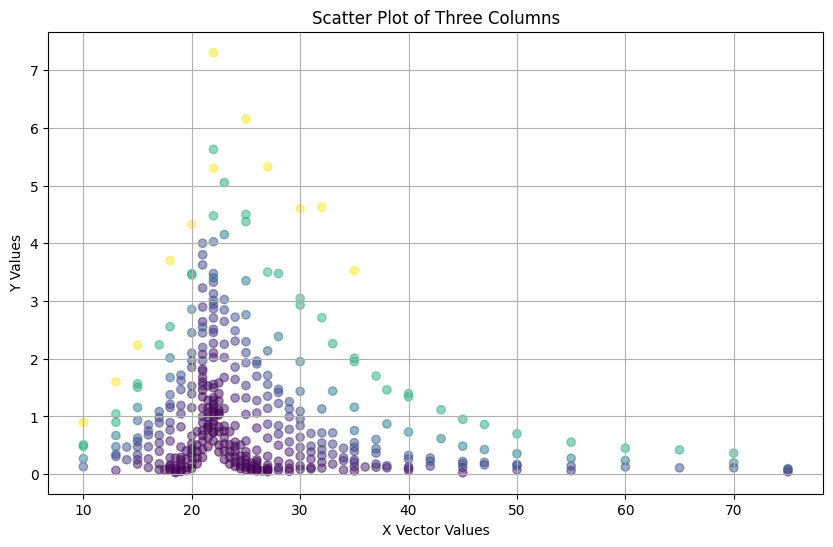

In [8]:
plt.figure(figsize=(10, 6))

all_cals_clean_exp = all_cals_clean[all_cals_clean['T']<=10]
all_puts_clean_exp = all_puts_clean[all_puts_clean['T']<=10]

plt.scatter(all_cals_clean_exp['K'], all_cals_clean_exp['calls'], alpha=0.5, marker='o', c=all_cals_clean_exp['T'], cmap='viridis')
plt.scatter(all_puts_clean_exp['K'], all_puts_clean_exp['puts'], alpha=0.5, marker='o', c=all_puts_clean_exp['T'], cmap='viridis')

# Add labels and legend
plt.xlabel('X Vector Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of Three Columns')

plt.grid(True)
plt.show()

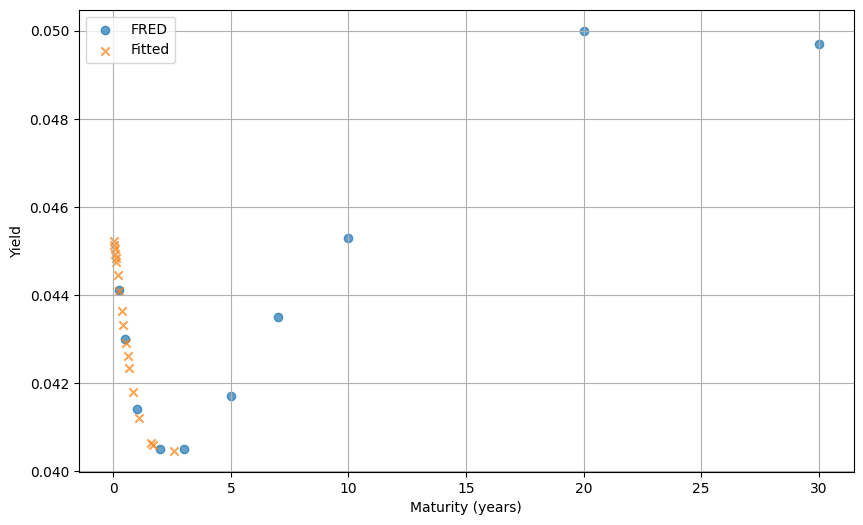

In [9]:
plt.figure(figsize=(10, 6))

r_interp = interp1d(r_term['T'], r_term['r'], kind='cubic', fill_value="extrapolate")
plt.scatter(r_term['T'], r_term['r'], alpha=0.7, marker='o', label='FRED')
plt.scatter(all_puts_clean['T'].unique(),r_interp(all_puts_clean['T'].unique()), alpha=0.7, marker='x', label='Fitted')

# Add labels and legend
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
# plt.title('Interest term structure')
plt.legend()

plt.grid(True)
plt.show()

# Callibrate Vanilla Model

In [10]:
params_BATES = {'kappa':0.4963,
                'theta':0.065,
                'sigma_v':0.2286,
                'rho': - 0.99,
                'v0': 0.0576,
                'lambda': 0.1382,
                'muJ': 0.1791,
                'sigmaJ': 0.1346}

#NMAPE
params_BATES = {'kappa': 0.08226411384605921,
                'theta': 0.035419879732212216,
                'sigma_v': 0.173967240604064,
                'rho': -0.999,
                'v0': 0.1355681207728808,
                'lambda': 1.5473124681537296,
                'muJ': 0.061536279991708964,
                'sigmaJ': 0.2382186163026844}

In [11]:
modcab = ModelCalibrator('BATES', S0, r_term, q_term,  all_cals_clean, all_puts_clean, params_BATES)

bounds_BATES = {'kappa': (0.01,10),
                'theta':(0.01,1),
                'sigma_v': (0.01,2),
                'rho': (-0.999, 0.999),
                'v0': (0.01,1),
                'lambda': (0,10),
                'muJ': (-1,1),
                'sigmaJ': (0.01,0.5)}

modcab.set_bounds(bounds_BATES)
positive_only = ['kappa', 'theta', 'sigma_v', 'v0', 'sigmaJ']

sortedcalls= all_cals_clean.sort_values(['K','T'])
sortedputs= all_puts_clean.sort_values(['K','T'])

weight = np.concatenate([sortedcalls['openInterest'].values,
                         sortedputs['openInterest'].values])
# weight_moneyness = np.concatenate([10*np.exp(-10*(S0/sortedcalls['K'].values-1)**2),
#                                    10*np.exp(-10*(S0/sortedputs['K'].values-1)**2)])

weight_moneyness = np.concatenate([10*np.exp(-6*np.abs(S0 - sortedcalls['K'].values)/(np.abs(S0) + np.abs(sortedcalls['K'].values))), 
                                   10*np.exp(-6*np.abs(S0 - sortedputs['K'].values)/(np.abs(S0) + np.abs(sortedputs['K'].values)))])

weight_T = np.concatenate([1*np.exp(-1*sortedcalls['T'].values**2),
                           1*np.exp(-1*sortedputs['T'].values**2)])

weight_mT = weight_moneyness*weight_T

# modcab.calibrate(positive_only, weight_mT, 'NMAPE', 1e-5,  N=2**14, eta=0.2)

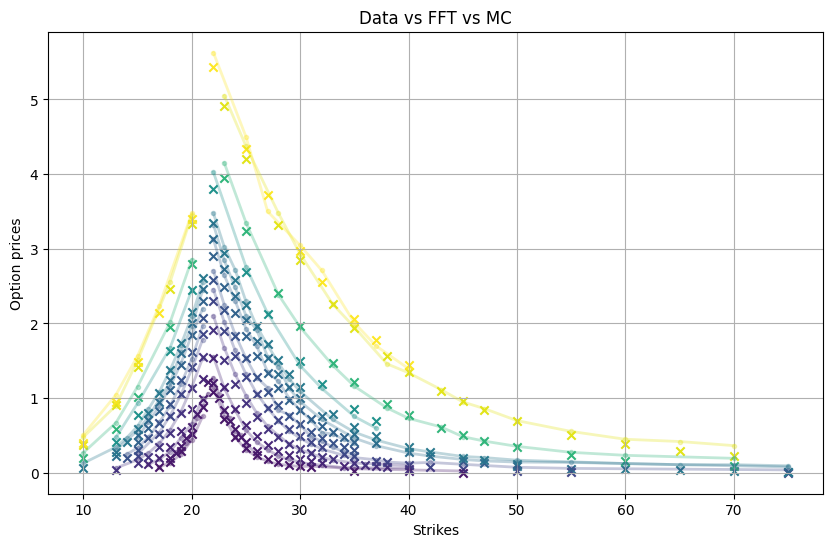

In [12]:
prices = modcab.calculate_prices(calls_data=all_cals_clean, puts_data=all_puts_clean)

prices['key'] = prices['K'].round(3).astype(str) + "_" + prices['T'].round(6).astype(str)


keys_calls = all_cals_clean['K'].round(3).astype(str) + "_" + all_cals_clean['T'].round(6).astype(str)
keys_puts = all_puts_clean['K'].round(3).astype(str) + "_" + all_puts_clean['T'].round(6).astype(str)

plt.figure(figsize=(10, 6))

uT = 2
lT = 0.1

all_cals_clean__plot = all_cals_clean[(all_cals_clean['T']<=uT) & (all_cals_clean['T']>=lT) & (all_cals_clean['K']>=(S0))]
all_puts_clean__plot = all_puts_clean[(all_puts_clean['T']<=uT) & (all_puts_clean['T']>=lT) & (all_puts_clean['K']<(S0))]

prices_calls = prices[(prices['T']<=uT) & (prices['T']>=lT) & (prices['key'].isin(keys_calls)) & (prices['K']>=(S0))]
prices_puts = prices[(prices['T']<=uT) & (prices['T']>=lT) & (prices['K']<(S0)) & (prices['key'].isin(keys_puts))]

for T_val, group in all_cals_clean__plot.groupby('T'):
    plt.plot(
        group['K'], 
        group['calls'], 
        marker='.', 
        linestyle='-',
        lw=2, 
        alpha=0.3,
        c=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in prices_calls.groupby('T'):
    plt.scatter(
        group['K'], 
        group['calls'], 
        marker='x', 
        alpha=1,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

    
for T_val, group in all_puts_clean__plot.groupby('T'):
    plt.plot(
        group['K'], 
        group['puts'], 
        marker='.', 
        linestyle='-',
        lw = 2, 
        alpha=0.3,
        c=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in prices_puts.groupby('T'):
    plt.scatter(
        group['K'], 
        group['puts'], 
        marker='x', 
        alpha=1,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )


# Add labels and legend
plt.xlabel('Strikes')
plt.ylabel('Option prices')
plt.title('Data vs FFT vs MC')

plt.grid(True)
plt.show()

# Simulate and price Exotic structure


In [13]:
from MCpricing import MCsim

In [14]:
# Parameters
T = 3
n_paths = 20000
n_steps = 2520

sim = MCsim('Bates', n_steps, n_paths, S0, T, modcab.params, dismethod='Milstein')
sim.load_paths(np.load('stockpaths_1.npy'))
# sim.simulate(r_term, 0.0)

In [15]:
# np.save('stockpaths_1.npy',sim.stockpaths)
# stockpaths = np.load('stockpaths_1.npy')


In [50]:
prices

,K,T,q,r,calls,puts,key
0,10.0,0.024658,0.0,0.045229,11.611164,0.000018,10.0_0.024658
1,10.0,0.043836,0.0,0.045128,11.619813,0.000051,10.0_0.043836
2,10.0,0.063014,0.0,0.045028,11.628438,0.000104,10.0_0.063014
3,10.0,0.082192,0.0,0.044929,11.637046,0.000185,10.0_0.082192
4,10.0,0.101370,0.0,0.044831,11.645644,0.000302,10.0_0.10137
...,...,...,...,...,...,...,...
859,75.0,0.849315,0.0,0.041788,0.030654,50.815522,75.0_0.849315
860,75.0,1.095890,0.0,0.041200,0.063263,50.152301,75.0_1.09589
861,75.0,1.597260,0.0,0.040622,0.172571,48.860739,75.0_1.59726
862,75.0,1.673973,0.0,0.040585,0.194277,48.668160,75.0_1.673973


In [16]:
vanilla_prices = sim.vanilla_price_batch(r_term, prices[['K','T']], sim.stockpaths)

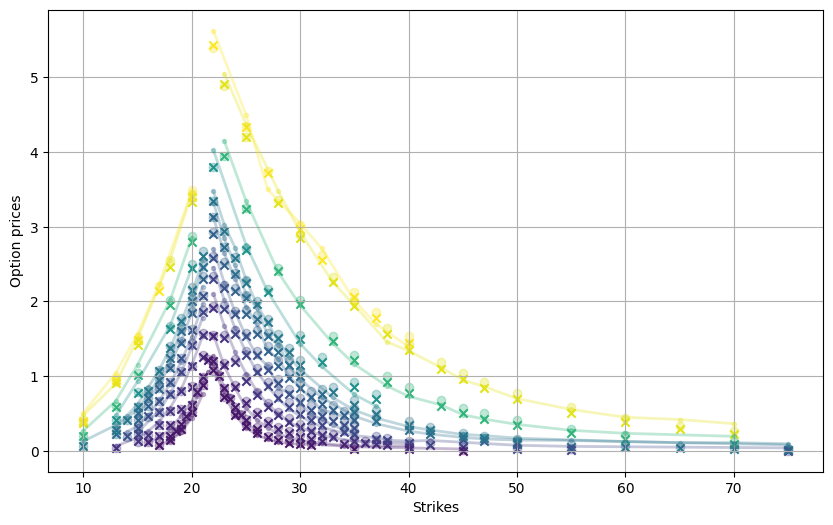

In [17]:
plt.figure(figsize=(10, 6))

uT = 2
lT = 0.1

vanilla_prices['key'] = vanilla_prices['K'].round(3).astype(str) + "_" + vanilla_prices['T'].round(6).astype(str)

vanilla_prices_calls = vanilla_prices[(vanilla_prices['T']<=uT) & (vanilla_prices['T']>=lT) & (vanilla_prices['key'].isin(keys_calls)) & (vanilla_prices['K']>=(S0))]
vanilla_prices_puts = vanilla_prices[(vanilla_prices['T']<=uT) & (vanilla_prices['T']>=lT) & (vanilla_prices['K']<(S0)) & (vanilla_prices['key'].isin(keys_puts))]

# plt.scatter(prices_calls['K'], prices_calls['calls'], alpha=0.5, marker='x', c=plt.cm.viridis(all_cals_clean__plot['T'] / all_cals_clean__plot['T'].max())) #, cmap='viridis')
# plt.scatter(all_cals_clean__plot['K'], all_cals_clean__plot['calls'], alpha=0.5, marker='.', c=all_cals_clean__plot['T'], cmap='viridis')
# plt.scatter(prices_puts['K'], prices_puts['puts'], alpha=0.5, marker='x', c=prices_puts['T'], cmap='viridis')
# plt.scatter(all_puts_clean__plot['K'], all_puts_clean__plot['puts'], alpha=0.5, marker='.', c=all_puts_clean__plot['T'], cmap='viridis')

for T_val, group in all_cals_clean__plot.groupby('T'):
    plt.plot(
        group['K'], 
        group['calls'], 
        marker='.', 
        linestyle='-',
        lw=2, 
        alpha=0.3,
        c=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in prices_calls.groupby('T'):
    plt.scatter(
        group['K'], 
        group['calls'], 
        marker='x', 
        alpha=1,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in vanilla_prices_calls.groupby('T'):
    plt.scatter(
        group['K'], 
        group['calls'], 
        marker='o', 
        alpha=0.3,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )
    
for T_val, group in all_puts_clean__plot.groupby('T'):
    plt.plot(
        group['K'], 
        group['puts'], 
        marker='.', 
        linestyle='-',
        lw = 2, 
        alpha=0.3,
        c=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in prices_puts.groupby('T'):
    plt.scatter(
        group['K'], 
        group['puts'], 
        marker='x', 
        alpha=1,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

for T_val, group in vanilla_prices_puts.groupby('T'):
    plt.scatter(
        group['K'], 
        group['puts'], 
        marker='o', 
        alpha=0.3,
        color=plt.cm.viridis(T_val / all_cals_clean__plot['T'].max())
    )

# Add labels and legend
plt.xlabel('Strikes')
plt.ylabel('Option prices')
# plt.title('Data vs FFT vs MC')

plt.grid(True)
plt.show()

# Optimal HKT

In [28]:
HKT = [10/21.5,21.5/21.6,1]

In [29]:
result = sim.best_HKT_barrier(S0, r_term, HKT, bounds=[(0.001,0.99),(0.99,0.999), (0.99,1.01)], w =[1,1] ,  method='Nelder-Mead')
print(result)

c:\Users\iskan\OneDrive\Desktop\studies\University\KU_study\FE\BonusCert\MCpricing.py:276: OptimizeWarning: Unknown solver options: ftol
  result = minimize(objective,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.0511682200826176
             x: [ 4.883e-01  9.989e-01  9.938e-01]
           nit: 66
          nfev: 127
 final_simplex: (array([[ 4.883e-01,  9.989e-01,  9.938e-01],
                       [ 4.883e-01,  9.989e-01,  9.938e-01],
                       [ 4.882e-01,  9.989e-01,  9.938e-01],
                       [ 4.883e-01,  9.989e-01,  9.938e-01]]), array([ 1.051e+00,  1.051e+00,  1.051e+00,  1.051e+00]))


In [30]:
H = np.floor(np.floor(result.x[1]*S0)*result.x[0])
print(H)

10.0


# Delta-hedging

In [38]:
vol = np.std(sim.returns)/np.sqrt(1/n_steps)*np.sqrt(1)
print(vol*100)

46.676978292428636


In [47]:
epsilon = 0.005*S0
sim.change_S0(S0+epsilon)
barrier_price_u = sim.down_barrier_price_single(0.0414, 21.5, 1, 5)
sim.change_S0(S0-epsilon)
barrier_price_d = sim.down_barrier_price_single(0.0414, 21.5, 1, 5)

delta = {}
for key in barrier_price_u.keys():
    delta[key] = (barrier_price_u[key]-barrier_price_d[key])/epsilon/2

print(delta)

{'DOBC_5': 0.6233916143921809, 'DIBC_5': 0.009873539194822959, 'DOBP_5': -0.2225931671542157, 'DIBP_5': -0.13901257426461125}


In [48]:
sim.change_S0(S0)
barrier_price = sim.down_barrier_price_single(0.0414, 21.5, 1, 5)
print(barrier_price)

{'DOBC_5': 4.290893381684559, 'DIBC_5': 0.04856195632918355, 'DOBP_5': 2.2358590476431397, 'DIBP_5': 1.2424583722909757}


In [49]:
product_price = S0+barrier_price['DOBP_5']
print(product_price)

23.83585904764314


In [55]:
KTdf = pd.DataFrame({'K':[21,21.5], 'T':[1,1],})

vanilla = sim.vanilla_price_batch(r_term, KTdf, sim.stockpaths)

In [56]:
vanilla

,K,T,r,calls,puts
0,21.0,1,0.0414,4.561961,3.221100
1,21.5,1,0.0414,4.339455,3.478317


In [81]:
knock = np.min(sim.stockpaths, axis=0) <= 5

In [82]:
np.sum(knock)/len(knock)

0.14295

In [37]:
(-delta['DOBP_5'] -1)*1_000_000/S0

-35981.7781860214